# Human numbers

In [1]:
from fastai.text import *

In [2]:
bs=64

## Data

In [3]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[PosixPath('/storage/human_numbers/train.txt'),
 PosixPath('/storage/human_numbers/valid.txt')]

In [4]:
def readnums(d): return [', '.join(o.strip() for o in open(path/d).readlines())]

In [5]:
train_txt = readnums('train.txt'); train_txt[0][:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [6]:
valid_txt = readnums('valid.txt'); valid_txt[0][-80:]

' nine thousand nine hundred ninety eight, nine thousand nine hundred ninety nine'

In [7]:
# use TextList to create an ItemList with text in
train = TextList(train_txt, path=path)
valid = TextList(valid_txt, path=path)

src = ItemLists(path=path, train=train, valid=valid).label_for_lm()
data = src.databunch(bs=bs)

In [8]:
# xxbos is the 'beginning of string' tag: the start of the document
train[0].text[:80]

'xxbos one , two , three , four , five , six , seven , eight , nine , ten , eleve'

In [9]:
# number of tokens in the dataset
len(data.valid_ds[0][0].data)

13017

In [10]:
# bptt is backprop through time : the sequence length. Look at 70 words at a time
data.bptt, len(data.valid_dl)

(70, 3)

In [11]:
# 2.9 batches for the dataset
13017/70/bs

2.905580357142857

In [12]:
# grabbing 3 batches
it = iter(data.valid_dl)
x1,y1 = next(it)
x2,y2 = next(it)
x3,y3 = next(it)
it.close()

In [13]:
x1.numel()+x2.numel()+x3.numel()

13440

In [14]:
x1.shape,y1.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [15]:
x2.shape,y2.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [16]:
# numericalised version of the first batch of x
x1[:,0]

tensor([ 2,  9, 11, 12, 13, 11, 10,  9, 10, 14, 19, 25, 19, 15, 16, 11, 19,  9,
        10,  9, 19, 25, 19, 11, 19, 11, 10,  9, 19, 20, 11, 26, 20, 23, 20, 20,
        24, 20, 11, 14, 11, 11,  9, 14,  9, 20, 10, 20, 35, 17, 11, 10,  9, 17,
         9, 20, 10, 20, 11, 20, 11, 20, 20, 20], device='cuda:0')

In [17]:
# y is offset from x: we want to predict the next word
y1[:,0]

tensor([19, 19, 27, 10,  9, 12, 32, 19, 26, 10, 11, 15, 11, 10,  9, 15, 11, 19,
        26, 19, 11, 18, 11, 18,  9, 18, 21, 19, 10, 10, 20,  9, 11, 16, 11, 11,
        13, 11, 13,  9, 13, 14, 20, 10, 20, 11, 24, 11,  9,  9, 16, 17, 20, 10,
        20, 11, 24, 11, 19,  9, 19, 11, 11, 10], device='cuda:0')

In [18]:
# grab the vocab - can convert numericalised version into text 
v = data.valid_ds.vocab

In [19]:
v.textify(x1[0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight'

In [20]:
v.textify(y1[0])

'eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand'

In [21]:
v.textify(x2[0])

'thousand eighteen , eight thousand nineteen , eight thousand twenty , eight thousand twenty one , eight thousand twenty two , eight thousand twenty three , eight thousand twenty four , eight thousand twenty five , eight thousand twenty six , eight thousand twenty seven , eight thousand twenty eight , eight thousand twenty nine , eight thousand thirty , eight thousand thirty one , eight thousand thirty two ,'

In [23]:
v.textify(x3[0])

'eight thousand thirty three , eight thousand thirty four , eight thousand thirty five , eight thousand thirty six , eight thousand thirty seven , eight thousand thirty eight , eight thousand thirty nine , eight thousand forty , eight thousand forty one , eight thousand forty two , eight thousand forty three , eight thousand forty four , eight thousand forty five , eight thousand forty six , eight'

In [24]:
v.textify(x1[1])

', eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine ,'

In [25]:
v.textify(x2[1])

'eight thousand sixty , eight thousand sixty one , eight thousand sixty two , eight thousand sixty three , eight thousand sixty four , eight thousand sixty five , eight thousand sixty six , eight thousand sixty seven , eight thousand sixty eight , eight thousand sixty nine , eight thousand seventy , eight thousand seventy one , eight thousand seventy two , eight thousand seventy three , eight thousand'

In [26]:
v.textify(x3[1])

'seventy four , eight thousand seventy five , eight thousand seventy six , eight thousand seventy seven , eight thousand seventy eight , eight thousand seventy nine , eight thousand eighty , eight thousand eighty one , eight thousand eighty two , eight thousand eighty three , eight thousand eighty four , eight thousand eighty five , eight thousand eighty six , eight thousand eighty seven , eight thousand eighty'

In [27]:
v.textify(x3[-1])

'ninety , nine thousand nine hundred ninety one , nine thousand nine hundred ninety two , nine thousand nine hundred ninety three , nine thousand nine hundred ninety four , nine thousand nine hundred ninety five , nine thousand nine hundred ninety six , nine thousand nine hundred ninety seven , nine thousand nine hundred ninety eight , nine thousand nine hundred ninety nine xxbos eight thousand one , eight'

In [28]:
data.show_batch(ds_type=DatasetType.Valid)

idx,text
0,"thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight thousand sixty , eight thousand sixty"
1,"eight , eight thousand eighty nine , eight thousand ninety , eight thousand ninety one , eight thousand ninety two , eight thousand ninety three , eight thousand ninety four , eight thousand ninety five , eight thousand ninety six , eight thousand ninety seven , eight thousand ninety eight , eight thousand ninety nine , eight thousand one hundred , eight thousand one hundred one , eight thousand one"
2,"thousand one hundred twenty four , eight thousand one hundred twenty five , eight thousand one hundred twenty six , eight thousand one hundred twenty seven , eight thousand one hundred twenty eight , eight thousand one hundred twenty nine , eight thousand one hundred thirty , eight thousand one hundred thirty one , eight thousand one hundred thirty two , eight thousand one hundred thirty three , eight thousand"
3,"three , eight thousand one hundred fifty four , eight thousand one hundred fifty five , eight thousand one hundred fifty six , eight thousand one hundred fifty seven , eight thousand one hundred fifty eight , eight thousand one hundred fifty nine , eight thousand one hundred sixty , eight thousand one hundred sixty one , eight thousand one hundred sixty two , eight thousand one hundred sixty three"
4,"thousand one hundred eighty three , eight thousand one hundred eighty four , eight thousand one hundred eighty five , eight thousand one hundred eighty six , eight thousand one hundred eighty seven , eight thousand one hundred eighty eight , eight thousand one hundred eighty nine , eight thousand one hundred ninety , eight thousand one hundred ninety one , eight thousand one hundred ninety two , eight thousand"


## Single fully connected model

In [29]:
data = src.databunch(bs=bs, bptt=3)

In [30]:
x,y = data.one_batch()
x.shape,y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [31]:
nv = len(v.itos); nv

40

In [32]:
nh=64

In [33]:
def loss4(input,target): return F.cross_entropy(input, target[:,-1])
def acc4 (input,target): return accuracy(input, target[:,-1])

Model below:
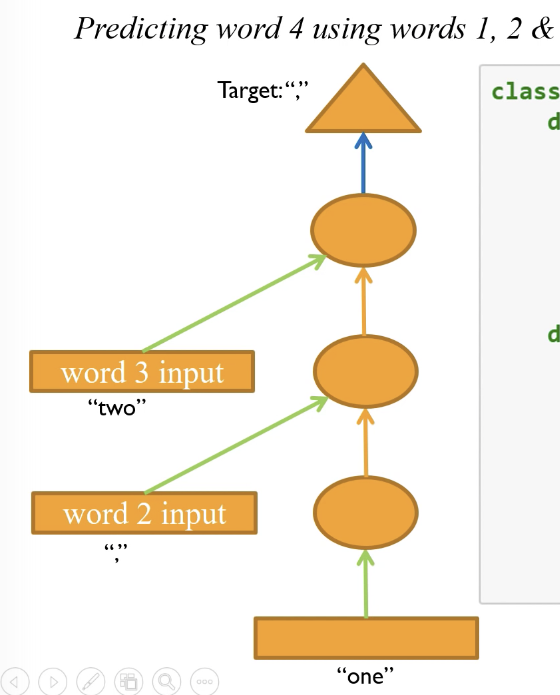</img>

In [34]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)  # green arrow
        self.h_h = nn.Linear(nh,nh)     # brown arrow
        self.h_o = nn.Linear(nh,nv)     # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = self.bn(F.relu(self.h_h(self.i_h(x[:,0]))))
        if x.shape[1]>1:
            h = h + self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1]>2:
            h = h + self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [35]:
learn = Learner(data, Model0(), loss_func=loss4, metrics=acc4)

In [36]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.689873,3.720861,0.024816,00:01
1,3.099617,3.144072,0.444853,00:01
2,2.473622,2.581726,0.463925,00:01
3,2.145487,2.314356,0.464844,00:01
4,2.019443,2.225783,0.470358,00:01
5,1.993518,2.213278,0.470358,00:01


## Same thing with a loop
Just refactoring the above model into a loop. This is an RNN!

In [37]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)  # green arrow
        self.h_h = nn.Linear(nh,nh)     # brown arrow
        self.h_o = nn.Linear(nh,nv)     # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [38]:
learn = Learner(data, Model1(), loss_func=loss4, metrics=acc4)

In [39]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.600934,3.576162,0.055377,00:01
1,3.051751,3.070419,0.409697,00:01
2,2.483510,2.604029,0.446461,00:01
3,2.163681,2.367505,0.453125,00:01
4,2.040612,2.290241,0.446232,00:01
5,2.015095,2.279919,0.439108,00:01


## Multi fully connected model
Instead of predicting the (n+1)th word from the nth, let's predict the (n+2)th from the (n+1)th etc.

After every loop of the RNN, we also predict.

In [40]:
data = src.databunch(bs=bs, bptt=20)

In [41]:
x,y = data.one_batch()
x.shape,y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [42]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        res = []
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            # every time we go through the loop we append the prediction to the results
            res.append(self.h_o(self.bn(h)))
        return torch.stack(res, dim=1)

In [43]:
learn = Learner(data, Model2(), metrics=accuracy)

In [44]:
# this is worse because we have a smaller number of words in state at any point (torch.zeros in forward pass resets
# state)
learn.fit_one_cycle(10, 1e-4, pct_start=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.751914,3.799446,0.014489,00:00
1,3.662213,3.690748,0.058026,00:00
2,3.552164,3.589530,0.118892,00:00
3,3.439770,3.496063,0.191335,00:00
4,3.334620,3.415604,0.243466,00:00
5,3.244772,3.355627,0.266477,00:00
6,3.175076,3.316796,0.306960,00:00
7,3.126388,3.295733,0.325994,00:00
8,3.096480,3.287634,0.333736,00:00
9,3.080877,3.286428,0.335085,00:00


## Maintain state
This is what a real RNN looks like: a fully connected neural net with a loop.

In [45]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        # creation of hidden state has been moved into constructor so it doesn't keep resetting
        self.h = torch.zeros(bs, nh).cuda()
        
    def forward(self, x):
        res = []
        h = self.h
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.bn(h))
        self.h = h.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res

In [46]:
learn = Learner(data, Model3(), metrics=accuracy)

In [47]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.670180,3.630187,0.060227,00:00
1,3.344731,3.017667,0.404616,00:00
2,2.658996,2.022356,0.465838,00:00
3,2.037142,1.948503,0.323224,00:00
4,1.706598,1.881278,0.373651,00:00
5,1.472652,1.766749,0.431463,00:00
6,1.270257,1.723877,0.421449,00:00
7,1.099649,1.659404,0.435582,00:00
8,0.965183,2.032526,0.426278,00:00
9,0.856130,1.835278,0.464134,00:00


## nn.RNN

In [48]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [49]:
learn = Learner(data, Model4(), metrics=accuracy)

In [50]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.538719,3.333592,0.250923,00:00
1,3.061611,2.525973,0.464560,00:00
2,2.385898,1.922250,0.467543,00:00
3,1.894347,2.013813,0.317259,00:00
4,1.607026,1.788691,0.444957,00:00
5,1.362724,1.737184,0.486009,00:00
6,1.151814,1.493208,0.529830,00:00
7,0.974573,1.422663,0.549290,00:00
8,0.823500,1.252770,0.596378,00:00
9,0.704729,1.191785,0.621875,00:00


## 2-layer GRU
Similar to before, but with an extra layer (see `self.GRU`).

To avoid vanishing gradients we use a GRU/LSTM instead.

In [69]:
n_layers = 4

class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.GRU(nh, nh, n_layers, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(n_layers, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [70]:
learn = Learner(data, Model5(), metrics=accuracy)

In [71]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.055005,2.775062,0.450071,00:00
1,1.722728,1.024432,0.739418,00:00
2,0.801196,0.762692,0.824574,00:00
3,0.385202,0.734762,0.836293,00:00
4,0.190693,0.744530,0.839702,00:00
5,0.098911,0.811847,0.838636,00:00
6,0.054241,0.772712,0.840199,00:00
7,0.031483,0.791882,0.842685,00:00
8,0.019278,0.833062,0.839489,00:00
9,0.012803,0.822540,0.839205,00:00


## fin